In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from operator import add
from sklearn import preprocessing
from statsmodels.formula.api import ols

In [3]:
def read_indata(path):
    '''
    This function is used when given the path read in data 

    :param path: a string of path saved the dataset
    :return: pandas datarame
    '''
    data = pd.read_csv(path)
    return data

In [4]:
def generate_year_month_day(df, colname):
    '''
    This function generate three new columns, which are year, month and day based on the variable 
    datetime
    
    :param df: dataframe we want to add column year and month
    :param colname: a stirng column name in the dataframe saved the dateandtime
    :return: dataframe after adding the column
    '''
    df['year'] = pd.DatetimeIndex(df[colname]).year
    df['month'] = pd.DatetimeIndex(df[colname]).month
    df['day'] = pd.DatetimeIndex(df[colname]).day
    return df

In [5]:
def get_city_weather(cityname, df_list, stringlist):
    """
    Extract the specific city's weather, including temperature, humidity, wind speed, from the 
    weather dataset 
    
    :param cityname: a string of cityname, like "Chicago"
    :param df_list: a list of dataframe 
    :param stringlist: a list of the name of these dataframe
    :return: a new list of dataframe, with some information updated  
    """
    new_df_list = []
    for i in range(len(stringlist)):
        citydf = df_list[i][(df_list[i].year>=2012) & (df_list[i].year<2018)].copy(deep=True)
        citydf = citydf[['year', 'month', 'day', cityname]]
        citydf[['year', 'month', 'day']] = citydf[['year', 'month', 'day']].astype(int)
        citydf = pd.DataFrame(citydf.groupby(['year', 'month', 'day']).mean())
        citydf = citydf.reset_index()
        citydf = citydf.rename(columns={cityname: stringlist[i]})

        new_df_list.append(citydf)
    return new_df_list




In [6]:

def merge_dataframe(df1, df2, mergeby):
    """
    
    :param df1: a dataframe 
    :param df2: a dataframe 
    :param mergeby: column names referred to merge om 
    :return: merged data
    """

    merged_data = pd.merge(df1, df2, on=mergeby, how='left')

    return merged_data


In [7]:
def mergeall_weather(new_df_list, mergeby):
    """
    This function is used to merge all the updated weather dataframe 
    
    :param new_df_list: updated list of weather dataframe from former step 
    :param mergeby: column named referred to merge om 
    :return: new dataframe merged all weather 
    """
    
    weather_all = new_df_list[0]
    for i in range(len(new_df_list) - 1):
        weather_all = merge_dataframe(weather_all, new_df_list[i+1], mergeby)
    return weather_all


In [8]:

def get_city(cityname, citycrime, weather_all):
    '''
    This function is used to get the merged crime data and weather data of the pointed city

    :param cityname: a string of the name of the city
    :param citycrime: the crime data of this city 
    :param weather_all: new dataframe merged all weather 
    :return: new dataframe 
    '''

    
    city_weather = weather_all[['year', 'month','day', cityname,'indextype']].copy(deep = True)
    citycrime_per_month = citycrime.groupby(['year', 'month', 'day']).size()
    citycrime_per_month = pd.DataFrame(citycrime_per_month.reset_index())
    citycrime_per_month = citycrime_per_month.rename(columns = {0:'Count'})
    citycrime_per_month[['year', 'month', 'day']] = citycrime_per_month[['year', 'month', 'day']].astype(int)

    city_weather[['year', 'month', 'day']] = city_weather[['year', 'month', 'day']].astype(int)

    crime_weather = pd.merge(city_weather[['year', 'month', 'day',cityname, 'indextype']], citycrime_per_month,
                             on=['year', 'month'], how='left')

    crime_weather = crime_weather[(crime_weather.year >= 2012) & (crime_weather.year < 2018)]
    crime_weather = crime_weather.rename(columns={cityname: 'indexvalue'})

    return crime_weather

In [9]:
def vectorize_humidity(df):
    """
    To vectorize the humidity 
    
    :param df: dataframe containing Humidity
    :return: a value after vectorize the humidity
    """
    if df['Humiditiy'] <= 0.45:
        val = 'Low'
    elif df['Humiditiy'] <= 0.65:
        val = 'Normal'
    elif df['Humiditiy'] > 0.65:
        val = 'High'
    return val


In [10]:
def vectorize_temperature(df):
    """
    To vectorize the Temperature 
    
    :param df: dataframe containing temperature
    :return: a value after vectorize
    """
    
    if df['Temperature'] <= 5:
        val = '0-5'
    elif df['Temperature'] <= 10:
        val = 5-10'
    elif df['Temperature'] <= 15:
        val = '10-15'
    elif df['Temperature'] <= 20:
        val = '15-20'
    elif df['Temperature'] <= 25:
        val = '20-25'
    elif df['Temperature'] <= 30:
        val = '25-30'
    elif df['Temperature'] > 30:
        val = '>30'
    return val


In [11]:
Humiditiy = read_indata('./historical-hourly-weather-data/humidity.csv')
Pressure = read_indata('./historical-hourly-weather-data/pressure.csv')
Temperature = read_indata('./historical-hourly-weather-data/temperature.csv')
weather_description = read_indata('./historical-hourly-weather-data/weather_description.csv')
wind_direction = read_indata('./historical-hourly-weather-data/wind_direction.csv')
wind_speed = read_indata('./historical-hourly-weather-data/wind_speed.csv')
chicago_crime = read_indata('./Chicago_crime_2012-2017.csv')

In [12]:
df_list = [Humiditiy, Pressure, Temperature, wind_direction,wind_speed]
stringlist = ['Humiditiy', 'Pressure', 'Temperature', 'wind_direction', 'wind_speed']

for index in range(len(df_list)):
    df = generate_year_month_day(df_list[index], 'datetime')


In [13]:
Humiditiy.head()

,datetime,Vancouver,Portland,San Francisco,Seattle,Los Angeles,San Diego,Las Vegas,Phoenix,Albuquerque,...,Boston,Beersheba,Tel Aviv District,Eilat,Haifa,Nahariyya,Jerusalem,year,month,day
0,2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,25.0,NaN,NaN,NaN,2012,10,1
1,2012-10-01 13:00:00,76.0,81.0,88.0,81.0,88.0,82.0,22.0,23.0,50.0,...,68.0,50.0,63.0,22.0,51.0,51.0,50.0,2012,10,1
2,2012-10-01 14:00:00,76.0,80.0,87.0,80.0,88.0,81.0,21.0,23.0,49.0,...,68.0,51.0,62.0,22.0,51.0,51.0,50.0,2012,10,1
3,2012-10-01 15:00:00,76.0,80.0,86.0,80.0,88.0,81.0,21.0,23.0,49.0,...,68.0,51.0,62.0,22.0,51.0,51.0,50.0,2012,10,1
4,2012-10-01 16:00:00,77.0,80.0,85.0,79.0,88.0,81.0,21.0,23.0,49.0,...,68.0,52.0,62.0,22.0,51.0,51.0,50.0,2012,10,1


In [14]:
new_df_list = get_city_weather('Chicago', df_list, stringlist)
weather_all = mergeall_weather(new_df_list, ['year', 'month', 'day'])

chicago_crime['year'] = chicago_crime.Date.str[6:10]
chicago_crime['month'] = chicago_crime.Date.str[0:2]
chicago_crime['day'] = chicago_crime.Date.str[3:5]


In [15]:
chicago_crime.head()

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,...,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location,year,month,day
0,11002368,JA329407,01/01/2012 12:00:00 AM,021XX N KENNETH AVE,1752,OFFENSE INVOLVING CHILDREN,AGG CRIM SEX ABUSE FAM MEMBER,RESIDENCE,False,True,...,NaN,NaN,2012,11/27/2017 03:53:35 PM,NaN,NaN,NaN,2012,01,01
1,9979416,HY169652,01/01/2012 12:00:00 AM,053XX W MONROE ST,1563,SEX OFFENSE,CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,...,1140801.0,1899144.0,2012,02/09/2018 03:44:29 PM,41.879335,-87.758468,"(41.879335159, -87.758467514)",2012,01,01
2,10433124,HZ170983,01/01/2012 12:00:00 AM,026XX N MC VICKER AVE,1544,SEX OFFENSE,SEXUAL EXPLOITATION OF A CHILD,RESIDENCE,True,False,...,NaN,NaN,2012,05/11/2016 03:48:18 PM,NaN,NaN,NaN,2012,01,01
3,9888481,HX538405,01/01/2012 12:00:00 AM,066XX S MAY ST,1153,DECEPTIVE PRACTICE,FINANCIAL IDENTITY THEFT OVER $ 300,RESIDENCE,False,False,...,1169793.0,1860812.0,2012,02/09/2018 03:44:29 PM,41.773566,-87.653128,"(41.773566189, -87.653127978)",2012,01,01
4,10593543,HZ344934,01/01/2012 12:00:00 AM,064XX W BELLE PLAINE AVE,1562,SEX OFFENSE,AGG CRIMINAL SEXUAL ABUSE,RESIDENCE,False,False,...,NaN,NaN,2012,07/12/2016 03:53:40 PM,NaN,NaN,NaN,2012,01,01


In [16]:
chi_crime_per_day = chicago_crime.groupby(['year', 'month', 'day', 'Primary Type', 'Arrest',  'Domestic']).size()
chi_crime_per_day= pd.DataFrame(chi_crime_per_day.reset_index())
chi_crime_per_day = chi_crime_per_day.rename(columns = {0:'Count'})
chi_crime_per_day[['year', 'month', 'day']] = chi_crime_per_day[['year', 'month', 'day']].astype(int)


In [17]:
chi_crime_per_day.head(20)

,year,month,day,Primary Type,Arrest,Domestic,Count
0,2012,1,1,ARSON,False,False,1
1,2012,1,1,ASSAULT,False,False,23
2,2012,1,1,ASSAULT,False,True,9
3,2012,1,1,ASSAULT,True,False,10
4,2012,1,1,ASSAULT,True,True,6
5,2012,1,1,BATTERY,False,False,96
6,2012,1,1,BATTERY,False,True,108
7,2012,1,1,BATTERY,True,False,30
8,2012,1,1,BATTERY,True,True,30
9,2012,1,1,BURGLARY,False,False,37


In [18]:
crime_weather= merge_dataframe(weather_all,chi_crime_per_day,['year', 'month', 'day'])
crime_weather = crime_weather.dropna()
crime_weather['Temperature'] = crime_weather['Temperature'] - 273.15


In [19]:
### Merged dataset 
crime_weather.head(20)

,year,month,day,Humiditiy,Pressure,Temperature,wind_direction,wind_speed,Primary Type,Arrest,Domestic,Count
0,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,ARSON,False,False,4
1,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,ASSAULT,False,False,33
2,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,ASSAULT,False,True,9
3,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,ASSAULT,True,False,15
4,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,ASSAULT,True,True,3
5,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,BATTERY,False,False,57
6,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,BATTERY,False,True,45
7,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,BATTERY,True,False,16
8,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,BATTERY,True,True,20
9,2012,10,1,68.909091,1014.0,11.402669,0.0,0.0,BURGLARY,False,False,75


In [20]:
crime_subset = crime_weather[['year', 'month', 'day','Humiditiy', 'Count','Primary Type']].copy(deep = True)




In [21]:
def normalize_humidity(df, colname):
    """
    This function is used to normalized the pointed column

    :param df: dataframe
    :param colname: column name
    :return: dataframe
    """
    minmaxnorm = (df[colname] - df[colname].min()) / (df[colname].max() - df[colname].min())
    df[colname] = minmaxnorm
   
    return df


crime_subset = normalize_humidity(crime_subset, 'Humiditiy')
crime_subset.head()

,year,month,day,Humiditiy,Count,Primary Type
0,2012,10,1,0.575067,4,ARSON
1,2012,10,1,0.575067,33,ASSAULT
2,2012,10,1,0.575067,9,ASSAULT
3,2012,10,1,0.575067,15,ASSAULT
4,2012,10,1,0.575067,3,ASSAULT


In [22]:

crime_subset['Reltaive Humidity'] = crime_subset.apply(vectorize_humidity, axis = 1)
crime_subset.head()

,year,month,day,Humiditiy,Count,Primary Type,Reltaive Humidity
0,2012,10,1,0.575067,4,ARSON,Normal
1,2012,10,1,0.575067,33,ASSAULT,Normal
2,2012,10,1,0.575067,9,ASSAULT,Normal
3,2012,10,1,0.575067,15,ASSAULT,Normal
4,2012,10,1,0.575067,3,ASSAULT,Normal


In [23]:
crime_count = pd.DataFrame(crime_subset.groupby(['Primary Type','Reltaive Humidity']).agg({'Count':np.sum}))
crime_count_total = crime_count.reset_index()

In [24]:
crime_count_total.head()

,Primary Type,Reltaive Humidity,Count
0,ARSON,High,1001
1,ARSON,Low,411
2,ARSON,Normal,823
3,ASSAULT,High,44198
4,ASSAULT,Low,16292


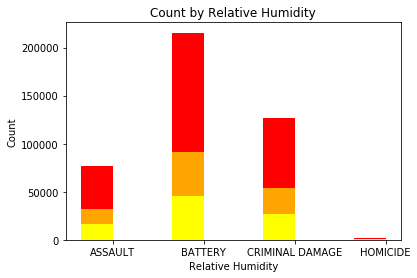

In [25]:
crime_count = crime_count_total.loc[crime_count_total['Primary Type'].isin(['ASSAULT','BATTERY', 'CRIMINAL DAMAGE','HOMICIDE'])]
fig, ax = plt.subplots()
N = len(set(crime_count['Primary Type']))
HighCounts = tuple(crime_count.loc[crime_count['Reltaive Humidity'] == 'High', 'Count'])
NormalCounts = tuple(crime_count.loc[crime_count['Reltaive Humidity'] == 'Normal', 'Count'])
LowCounts = tuple(crime_count.loc[crime_count['Reltaive Humidity'] == 'Low', 'Count'])
ind = np.arange(N)
width = 0.35

p1 = ax.bar(ind, LowCounts, width,color='Yellow')
p2 = ax.bar(ind, NormalCounts, width, color='Orange', bottom = LowCounts)
p3 = ax.bar(ind, HighCounts, width, color = 'Red', bottom = NormalCounts)
ax.set_ylabel('Count')
ax.set_xlabel('Relative Humidity')
ax.set_title('Count by Relative Humidity')
ax.set_xticks(ind + width / 2.)
#ax.set_yticks(np.arange(0, 81, 10))
ax.set_xticklabels(('ASSAULT','BATTERY', 'CRIMINAL DAMAGE','HOMICIDE'))
plt.show()

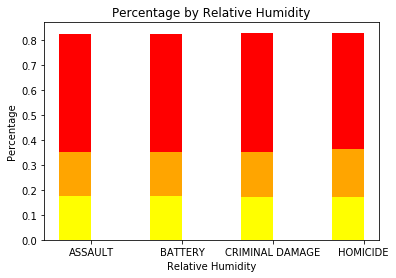

In [26]:
fig, ax = plt.subplots()
N = len(set(crime_count['Primary Type']))
HighCounts = list(crime_count.loc[crime_count['Reltaive Humidity'] == 'High', 'Count'])
NormalCounts = list(crime_count.loc[crime_count['Reltaive Humidity'] == 'Normal', 'Count'])
LowCounts = list(crime_count.loc[crime_count['Reltaive Humidity'] == 'Low', 'Count'])
totalCounts = list(map(sum, zip(HighCounts,NormalCounts,LowCounts)))


Highpercent = [x/y for x, y in zip(HighCounts, totalCounts)]
Normalpercent = [x/y for x, y in zip(NormalCounts, totalCounts)]
Lowpercent = [x/y for x, y in zip(LowCounts, totalCounts)]
ind = np.arange(N)
width = 0.35

p1 = ax.bar(ind, Lowpercent, width,color='Yellow')
p2 = ax.bar(ind, Normalpercent, width, color='Orange', bottom = Lowpercent)
p3 = ax.bar(ind, Highpercent, width, color = 'Red', bottom = Normalpercent)
ax.set_ylabel('Percentage')
ax.set_xlabel('Relative Humidity')
ax.set_title('Percentage by Relative Humidity')
ax.set_xticks(ind + width / 2.)
#ax.set_yticks(np.arange(0, 81, 10))
ax.set_xticklabels(('ASSAULT','BATTERY', 'CRIMINAL DAMAGE','HOMICIDE'))
plt.show()

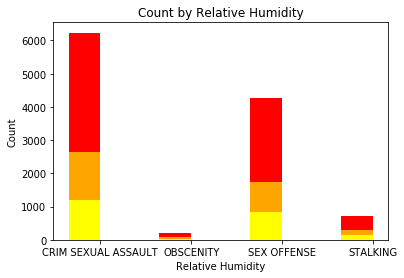

In [27]:
crime_count = crime_count_total.loc[crime_count_total['Primary Type'].isin(['CRIM SEXUAL ASSAULT','OBSCENITY', 'SEX OFFENSE','STALKING'])]
fig, ax = plt.subplots()
N = len(set(crime_count['Primary Type']))
HighCounts = tuple(crime_count.loc[crime_count['Reltaive Humidity'] == 'High', 'Count'])
NormalCounts = tuple(crime_count.loc[crime_count['Reltaive Humidity'] == 'Normal', 'Count'])
LowCounts = tuple(crime_count.loc[crime_count['Reltaive Humidity'] == 'Low', 'Count'])
ind = np.arange(N)
width = 0.35

p1 = ax.bar(ind, LowCounts, width,color='Yellow')
p2 = ax.bar(ind, NormalCounts, width, color='Orange', bottom = LowCounts)
p3 = ax.bar(ind, HighCounts, width, color = 'Red', bottom = NormalCounts)
ax.set_ylabel('Count')
ax.set_xlabel('Relative Humidity')
ax.set_title('Count by Relative Humidity')
ax.set_xticks(ind + width / 2.)
ax.set_xticklabels(('CRIM SEXUAL ASSAULT','OBSCENITY', 'SEX OFFENSE','STALKING'))
plt.show()

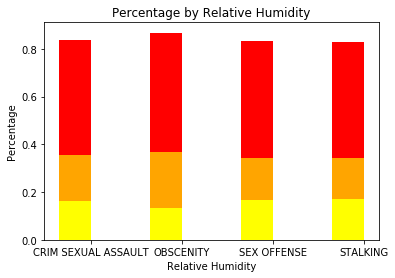

In [28]:
fig, ax = plt.subplots()
N = len(set(crime_count['Primary Type']))
HighCounts = list(crime_count.loc[crime_count['Reltaive Humidity'] == 'High', 'Count'])
NormalCounts = list(crime_count.loc[crime_count['Reltaive Humidity'] == 'Normal', 'Count'])
LowCounts = list(crime_count.loc[crime_count['Reltaive Humidity'] == 'Low', 'Count'])
totalCounts = list(map(sum, zip(HighCounts,NormalCounts,LowCounts)))


Highpercent = [x/y for x, y in zip(HighCounts, totalCounts)]
Normalpercent = [x/y for x, y in zip(NormalCounts, totalCounts)]
Lowpercent = [x/y for x, y in zip(LowCounts, totalCounts)]
ind = np.arange(N)
width = 0.35

p1 = ax.bar(ind, Lowpercent, width,color='Yellow')
p2 = ax.bar(ind, Normalpercent, width, color='Orange', bottom = Lowpercent)
p3 = ax.bar(ind, Highpercent, width, color = 'Red', bottom = Normalpercent)
ax.set_ylabel('Percentage')
ax.set_xlabel('Relative Humidity')
ax.set_title('Percentage by Relative Humidity')
ax.set_xticks(ind + width / 2.)
#ax.set_yticks(np.arange(0, 81, 10))
ax.set_xticklabels(('CRIM SEXUAL ASSAULT','OBSCENITY', 'SEX OFFENSE','STALKING'))
plt.show()

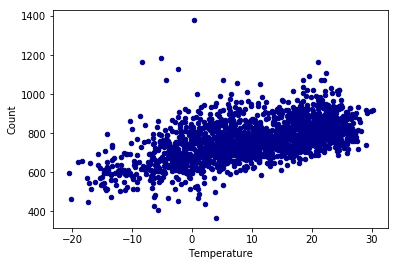

In [29]:
Temp_sub = crime_weather[['year', 'month', 'day', 'Temperature', 'Count', 'Primary Type']].copy(deep=True)

Temp_sub1 = pd.DataFrame(Temp_sub.groupby(['year','month','day']).agg({'Count': np.sum, 'Temperature': np.mean}))
Temp_sub1 = Temp_sub1.reset_index()

ax1 = Temp_sub1.plot.scatter(x='Temperature',y = 'Count',c = 'DarkBlue')
plt.show()

In [30]:

chicago_linear_model = ols("Count ~ Temperature", data=Temp_sub1).fit()
chicago_linear_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Count   R-squared:                       0.301
Model:                            OLS   Adj. R-squared:                  0.301
Method:                 Least Squares   F-statistic:                     812.3
Date:                Sun, 28 Apr 2019   Prob (F-statistic):          7.64e-149
Time:                        08:03:22   Log-Likelihood:                -11059.
No. Observations:                1885   AIC:                         2.212e+04
Df Residuals:                    1883   BIC:                         2.213e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept     709.6562      2.740    258.960      0.000     704.282     715.031
Temperature     5.3223      0.187     28.500      0.000       4.956       5.689
==============================================================================
Omnibus:                      400.875   Durbin-Watson:                   0.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1579.961
Skew:                           0.987   Prob(JB):                         0.00
Kurtosis:                       7.027   Cond. No.                         20.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

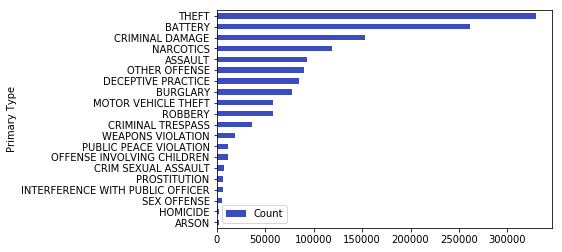

In [137]:
sort_crime_count = pd.DataFrame(Temp_sub.groupby(['Primary Type']).agg({'Count': np.sum}))

sort_crime_count = sort_crime_count.sort_values(by = "Count", ascending = True).tail(20)

sort_crime_count.plot(kind = 'barh',colormap= 'coolwarm')


In [147]:
avg_crime_count_bymonth = pd.DataFrame(Temp_sub.groupby(['Primary Type','month']).agg({'Count': np.sum}))
avg_crime_count_bymonth.head()
assault_bymonth = avg_crime_count_bymonth.loc['ASSAULT']
narcotics_bymonth = avg_crime_count_bymonth.loc['NARCOTICS']






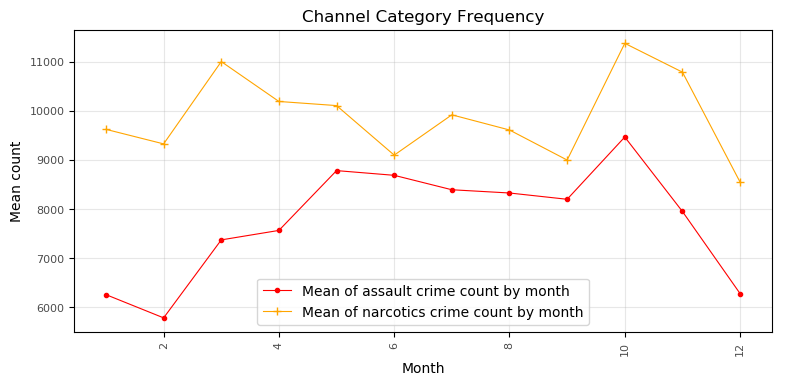

In [152]:
plt.figure(figsize=(9,4), dpi= 100)
plt.plot(assault_bymonth , linewidth = 0.8, marker = '.', label = "Mean of assault crime count by month", color='Red')
plt.plot(narcotics_bymonth, linewidth = 0.8, marker = '+', label = "Mean of narcotics crime count by month", color='Orange')

plt.xlabel("Month") 
plt.ylabel("Mean count") 
plt.xticks(horizontalalignment='center', alpha=.7, rotation=90, fontsize=8) 
plt.yticks(alpha=.7, fontsize=8) 
plt.title("Channel Category Frequency") 
plt.grid(axis='both', alpha=.3)
plt.legend()
plt.show()

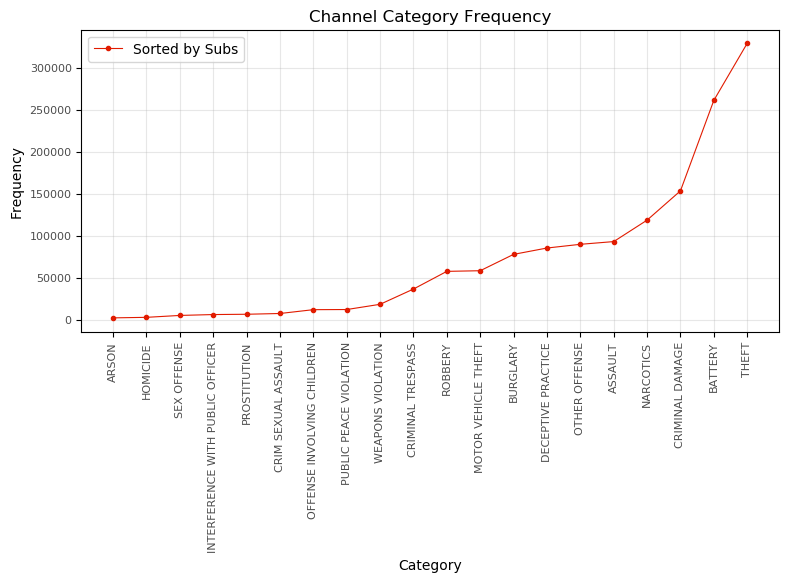

In [149]:


plt.figure(figsize=(9,4), dpi= 100)
plt.plot(sort_crime_count, linewidth = 0.8, marker = '.', label = "Sorted by Subs", color='#E11B00')

plt.xlabel("Category") 
plt.ylabel("Frequency") 

plt.xticks(horizontalalignment='center', alpha=.7, rotation=90, fontsize=8) 
plt.yticks(alpha=.7, fontsize=8) 
plt.title("Channel Category Frequency") 
plt.grid(axis='both', alpha=.3)
plt.legend()
plt.show()

In [150]:
Temp_sub['Temprange'] = Temp_sub.apply(vectorize_temperature, axis=1)

Temp_sub3 = pd.DataFrame(Temp_sub.groupby(['Primary Type','Temprange']).agg({'Count': np.sum}))

asc_temp_sub3 = Temp_sub3.sort_values(by = "Count", ascending = 0)

asc_temp_sub3.


SyntaxError: invalid syntax (<ipython-input-150-18e5f08ecaa9>, line 7)

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

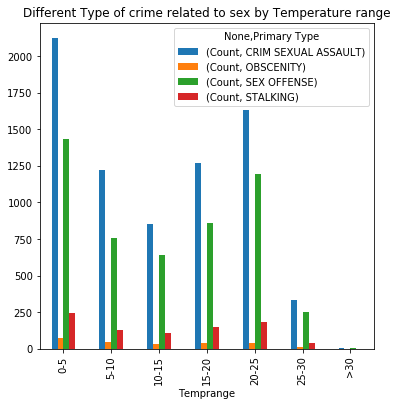

In [91]:
Temp_sub['Temprange'] = Temp_sub.apply(vectorize_temperature, axis=1)

Temp_sub.head()

Temp_sexual3 = Temp_sub.loc[Temp_sub['Primary Type'].isin(['CRIM SEXUAL ASSAULT','OBSCENITY', 'SEX OFFENSE','STALKING'])]

Temp_sub3 =Temp_sexual3.groupby(['Temprange','Primary Type']).agg({'Count': np.sum}).unstack()

Temp_sub3 = Temp_sub3.reindex(index = ['0-5', '5-10', '10-15', '15-20', '20-25', '25-30', '>30'])


Temp_sub3
Temp_sub3.plot(kind = 'bar', title = "Different Type of crime related to sex by Temperature range", figsize=(6,6))
plt.xticks(rotation=90)

